## XGBoost Modelltraining auf finalem Datensatz - ohne Inflationsdaten

für das Training wurde der Datensatz benutzt, bei dem unsere eigenen Features mit dem BSR Datensatz vereint wurden, 
bei denen auffällige Tonnagen im Jahr 2023 gemittelt wurden  
Da hier der gesamte Zeitraum von 2019-2023 für das Training mit einbezogen werden soll, werden die alle Spalten die Infaltionsdaten enthalten gelöscht, denn diese haben für das Jahr 2019 keine Werte

**Hinweis:** Für das Entfernen von unwichtigen Features wurden zwei unterschiedliche Methoden angewendet, 
so dass nachfolgend auch zweimal seperat ein HyperparameterTuning mit GridSearchCV gemacht worden ist und zwei unterschiedlich perfomende Modelle entstanden sind

In [120]:
import pandas as pd
import os

file_path = os.path.join( "..", "Daten",  "Merged_BSR_24Uhr_23mittel.csv")

df = pd.read_csv(file_path)  
df.tail()

,Schicht,Tour,Tonnage,Temperature_Max (°C),Rain_Sum (mm),Snowfall_Sum (cm),Wind_Speed_Max (km/h),Daylight_Duration (s),Temperature_Max (°C) 3-Day Avg,Rain_Sum (mm) 3-Day Avg,...,Feiertag_Pfingstmontag_shift_1,Feiertag_Pfingstmontag_shift_2,Feiertag_Tag der Arbeit_shift_1,Feiertag_Tag der Arbeit_shift_2,Feiertag_Tag der Befreiung_shift_1,Feiertag_Tag der Befreiung_shift_2,Feiertag_Tag der Deutschen Einheit_shift_1,Feiertag_Tag der Deutschen Einheit_shift_2,Feiertag_Zweiter Weihnachtstag_shift_1,Feiertag_Zweiter Weihnachtstag_shift_2
381656,1,5508,2.90,8.5,2.6,0.0,29.8,27757.76,9.8,3.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381657,1,2101,7.86,8.5,2.6,0.0,29.8,27757.76,9.8,3.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381658,1,2102,1.81,8.5,2.6,0.0,29.8,27757.76,9.8,3.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381659,1,3301,0.35,8.5,2.6,0.0,29.8,27757.76,9.8,3.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381660,1,3302,4.13,8.5,2.6,0.0,29.8,27757.76,9.8,3.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


----------
**Inflationsdaten herausnehmen**

In [107]:
#inflation droppen
df.drop(['   Brot', 'Fleisch', '    Fisch', '    Molkerei-Eier', '    Speisefette-öle', '    Obst', '    Gemüse',
         '    Zucker, Marmelade, Honig', '    Fertigerichte', '  Kaffee-Tee', '    Wasser-Saft'], axis=1, inplace=True)

-----------------------
**Vorbereitung der Daten für Training**

In [108]:
X = df.drop(columns=['Tonnage'])  # Features (alle Spalten außer Ziel)
y = df['Tonnage']  # Zielvariable




Das Splitten der Daten erfolgte unter Berücksichtigung derzeitlichene Komponente. 
Da dieser Split nach Jahren sehr einfach ist und das Jahr 2023 Auffälligkeiten in den Daten zeigt, ist anzunehmen, dass dies schon negative Auswirkungen auf das Modell haben kann.
Ein TimeSeries Split wäre sicher ein bessere Alternative gewesen. Da das Verständnis für dafür noch nicht komplett vorhanden war, wurde davon abgesehen.

In [121]:
# Trainingsdaten: 2019, 2020, 2021
X_train = X[X["year"].isin([2019, 2020, 2021])]
y_train = y[X["year"].isin([2019, 2020, 2021])]

# Validierungsdaten: 2022
X_val = X[X["year"] == 2022]
y_val = y[X["year"] == 2022]

# Testdaten: 2023
X_test = X[X["year"] == 2023]
y_test = y[X["year"] == 2023]

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Validation: {X_val.shape}")



Train: (223715, 79), Test: (78714, 79), Validation: (79232, 79)


-----------------------
**Training**

In [146]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import time  # Importiere time, um die Zeit zu messen
import numpy as np  # Für die Quadratwurzelberechnung

# XGBoost Modell initialisieren
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)


start_time = time.time()
# Modell mit Trainingsdaten (2019-2021) trainieren
model.fit(X_train.drop(columns=['year']), y_train)  
end_time = time.time()

train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val = model.predict(X_val.drop(columns=['year']))

# Berechnung der Fehlermaße
mae = mean_absolute_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))

# Ergebnisse ausgeben
print(f"Mean Absolute Error (MAE): {mae:.8f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")
print(f"R²-Score: {r2:.8f}")

# erst nach der Optimierung (z.B. Hyperparameter angepasst) - finale Evaluierung auf Testdaten (2022)
# das habe ich einmal zuvor schon gemacht gehabt, die Ergebnisse gespeichert und beim nochmaligen Bearbeiten des notebooks nicht mehr
#y_pred_test = model.predict(X_test.drop(columns=['year']))
#test_error = mean_absolute_error(y_test, y_pred_test)
#r2 = r2_score(y_test, y_pred_test)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
#print(f"MAE für Testjahr 2023: {test_error}")
#print(f"Root Mean Squared Error (RMSE) für Testjahr 2023: {rmse:.4f}")
#print(f"R²-Score für Testjahr 2023: {r2:.4f}")


Trainingszeit: 1.00 Sekunden
Mean Absolute Error (MAE): 2.44088462
Root Mean Squared Error (RMSE): 3.21406397
R²-Score: 0.69601983


**Mean Absolute Error (MAE): 2.4409**
Der MAE gibt die durchschnittliche absolute Differenz zwischen den tatsächlichen Werten und den vorhergesagten Werten des Modells an. Ein MAE von 2.4409 bedeutet, dass das Modell im Durchschnitt etwa 2.44 Einheiten von den tatsächlichen Werten abweicht. Ein niedrigerer MAE zeigt eine genauere Modellvorhersage.

**Root Mean Squared Error (RMSE): 3.2141**
Der RMSE misst die Quadratwurzel des durchschnittlichen quadratischen Fehlerwerts. Er gibt an, wie stark die Vorhersagen von den tatsächlichen Werten abweichen, wobei größere Fehler stärker gewichtet werden. In diesem Fall ist der RMSE 3.2141, was bedeutet, dass die Fehler im Durchschnitt etwa 3.21 Einheiten betragen. Der RMSE ist empfindlicher gegenüber größeren Fehlern, da er Fehler quadriert.

**R²-Score: 0.6960**
Der R²-Score (Bestimmtheitsmaß) zeigt an, wie gut das Modell die Variation der Zielgröße erklärt. Ein R² von 0.6960 bedeutet, dass das Modell etwa 69.6% der Variation der Zielgröße auf den Trainingsdaten erklärt. Ein R²-Score von 0.696 ist relativ gut und deutet darauf hin, dass das Modell die Daten gut modelliert hat, aber es gibt noch etwa 30% der Variation, die nicht erklärt wird (dies sind die Fehler).

-----------------------------
### Feature Selection

**relevante Features hearusfinden**

Um herauszufinden, ob Features für die Entscheidung und das Training besonders relevant waren und welche keinen Einfluss auf das Training haben, wurde diese nachfolgend untersucht.  
Wichtig ist hierbei zu wissen, dass Feature-Wichtigkeit unterschiedlich gemessen werden kann. 

Die wichtigsten Metriken für Feature Importance in XGBoost sind:
 - "weight" (auch "frequency" genannt): Anzahl der Male, die ein Feature für einen Split in den Bäumen verwendet wurde.
 - "gain": Der durchschnittliche Gewinn (Verbesserung der Vorhersagequalität), den das Feature bringt, wenn es für einen Split verwendet wird.
 - "cover": Durchschnittliche Anzahl von Datenpunkten, die ein Feature in den Splits beeinflusst.

Die Ergebnisse sind sehr unterschiedlich. Da es vor allem um die Verbesserung der Vorhersage geht, werden die Ergebnisse von "gain" genommen.

Feature Importance nach Gain:
                            Feature          Gain
42                     Abfallart_HM  60070.328125
19                        Wochentag   4713.562500
25                    Saison_Winter   4465.245605
1                              Tour   2021.606079
38                          Hof_VMN   1209.310913
36                          Hof_VMG   1091.726929
28                  Tonnage_dealy_1    894.985107
11  Daylight_Duration (s) 3-Day Avg    861.455688
37                          Hof_VMM    800.979065
29                  Tonnage_dealy_2    756.052490
20          TageZuvorNichtGeliefert    715.825684
30                  Tonnage_dealy_3    556.798401
32                  Tonnage_dealy_5    530.267334
21                        Ferientag    482.346100
31                  Tonnage_dealy_4    477.635956
35                  Tonnage_dealy_8    464.405029
34                  Tonnage_dealy_7    463.832153
22                  Saison_Frühling    340.837341
33                  

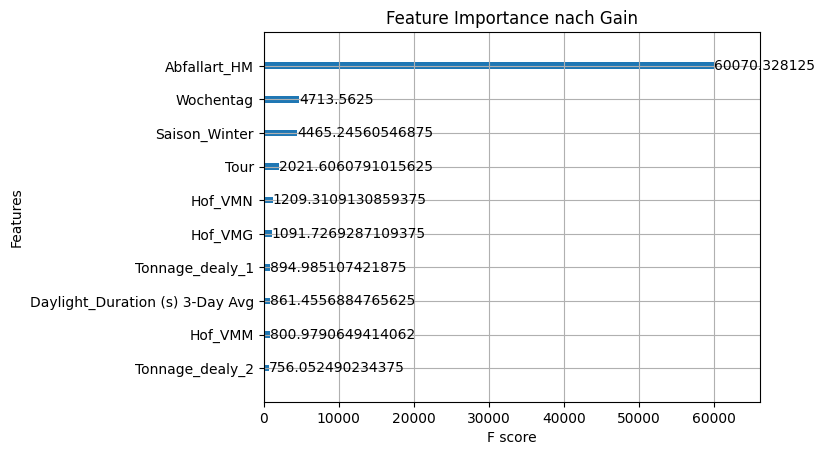

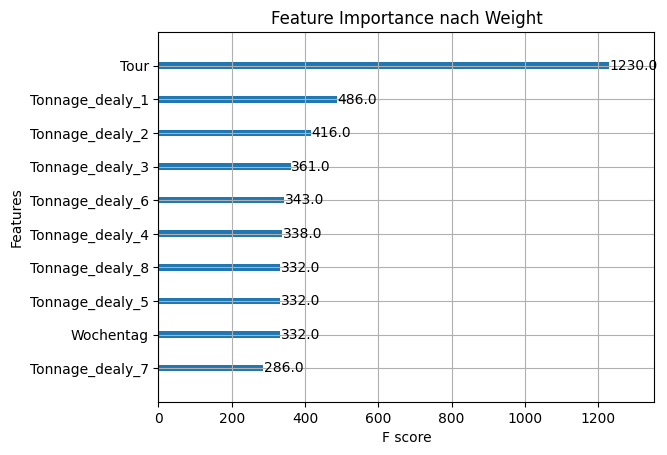

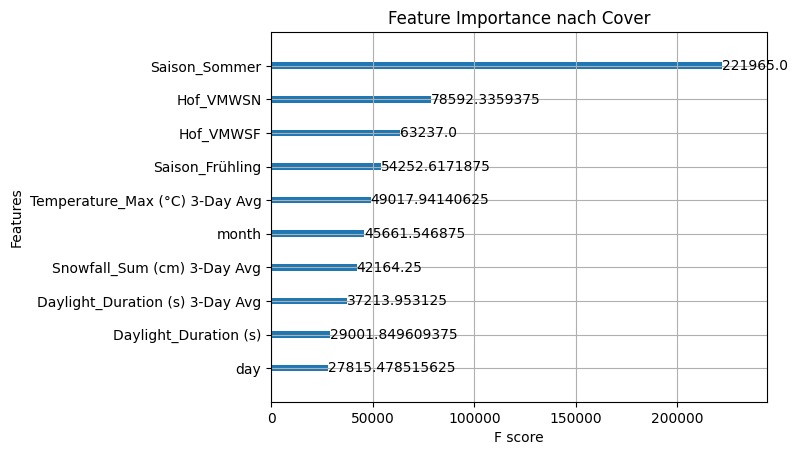

In [125]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importance mit verschiedenen Metriken holen
booster = model.get_booster()

importance_gain = booster.get_score(importance_type="gain")
importance_weight = booster.get_score(importance_type="weight")
importance_cover = booster.get_score(importance_type="cover")

# In DataFrames umwandeln
df_gain = pd.DataFrame(importance_gain.items(), columns=['Feature', 'Gain']).sort_values(by="Gain", ascending=False)
df_weight = pd.DataFrame(importance_weight.items(), columns=['Feature', 'Weight']).sort_values(by="Weight", ascending=False)
df_cover = pd.DataFrame(importance_cover.items(), columns=['Feature', 'Cover']).sort_values(by="Cover", ascending=False)

print("Feature Importance nach Gain:")
print(df_gain)

print("\nFeature Importance nach Weight:")
print(df_weight)

print("\nFeature Importance nach Cover:")
print(df_cover)

# Visualisieren
xgb.plot_importance(model, importance_type="gain", max_num_features=10)
plt.title("Feature Importance nach Gain")
plt.show()

xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.title("Feature Importance nach Weight")
plt.show()

xgb.plot_importance(model, importance_type="cover", max_num_features=10)
plt.title("Feature Importance nach Cover")
plt.show()


**-> nachfolgend der erste Ansatz die wichtigsten Features die behalten werden sollen, herauszufinden**   
da ich den Treshold so hoch gesetzt habe, 
sind natürlich alles features als unwichtig gesetzt worden, das erklärt mein weiteres vorgehen bei dem durch ausprobieren eine gute Anzahl an features gefunden haben, die das training verbessern.

ich habe später das ganze automatisiert gemacht

                                       Feature  Importance
54                                Abfallart_HM    0.708483
31                                   Wochentag    0.055593
37                               Saison_Winter    0.052664
1                                         Tour    0.023843
50                                     Hof_VMN    0.014263
48                                     Hof_VMG    0.012876
40                             Tonnage_dealy_1    0.010556
11             Daylight_Duration (s) 3-Day Avg    0.010160
49                                     Hof_VMM    0.009447
41                             Tonnage_dealy_2    0.008917
32                     TageZuvorNichtGeliefert    0.008443
42                             Tonnage_dealy_3    0.006567
44                             Tonnage_dealy_5    0.006254
33                                   Ferientag    0.005689
43                             Tonnage_dealy_4    0.005633
47                             Tonnage_dealy_8    0.0054

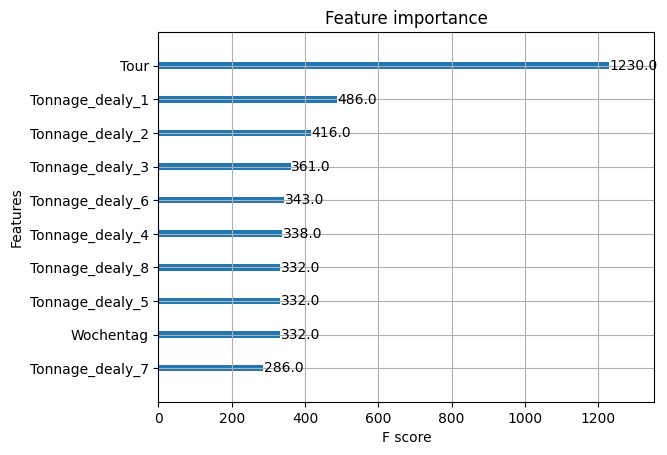

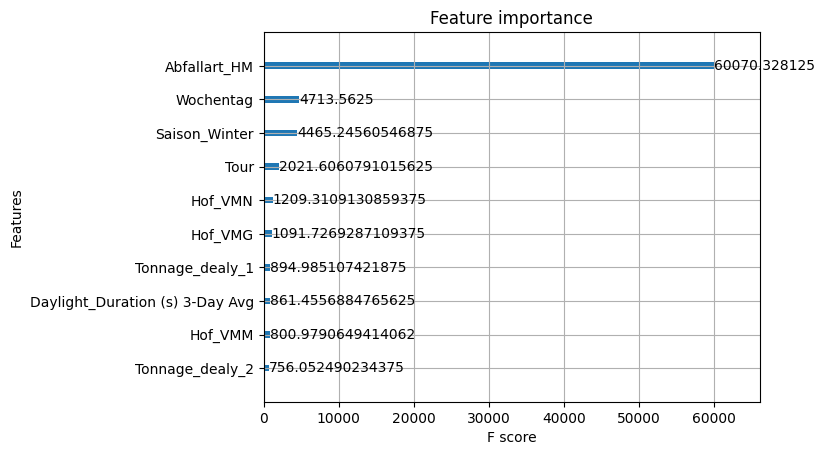

Unwichtige Features: 54                                  Abfallart_HM
31                                     Wochentag
37                                 Saison_Winter
1                                           Tour
50                                       Hof_VMN
48                                       Hof_VMG
40                               Tonnage_dealy_1
11               Daylight_Duration (s) 3-Day Avg
49                                       Hof_VMM
41                               Tonnage_dealy_2
32                       TageZuvorNichtGeliefert
42                               Tonnage_dealy_3
44                               Tonnage_dealy_5
33                                     Ferientag
43                               Tonnage_dealy_4
47                               Tonnage_dealy_8
46                               Tonnage_dealy_7
34                               Saison_Frühling
45                               Tonnage_dealy_6
51                                     Hof_VMWSF

In [127]:
import matplotlib.pyplot as plt

# nur die Spalten verwenden, die beim Training genutzt wurden
X_train_filtered = X_train.drop(columns=['year'])

# DataFrame mit Features + Importances erstellen
df_importance = pd.DataFrame({
    'Feature': X_train_filtered.columns,  # Hier NICHT X_train verwenden!
    'Importance': model.feature_importances_
})

# Sortieren nach Wichtigkeit
df_importance = df_importance.sort_values(by='Importance', ascending=False)
pd.set_option('display.max_rows', None)
print(df_importance)

xgb.plot_importance(model, importance_type="weight", max_num_features=10)
plt.show()

xgb.plot_importance(model, importance_type="gain", max_num_features=10)
plt.show()

threshold = 10  # Features mit weniger als dieser Wichtigkeit werden entfernt

# Finde Features, die unter der Schwelle liegen
unimportant_features = df_importance[df_importance['Importance'] < threshold]['Feature']

print("Unwichtige Features:", unimportant_features)

---
### unwichtige Features entfernen Methode 1
**unwichtige Features entfernen**

aus allen features werden die unwichtigen aus dem Datensatz entfernt

In [131]:
#unimportant_features = df_importance[df_importance['Importance'] < 0.004]['Feature'] #--> 45 Features fallen raus
unimportant_features = df_importance[df_importance['Importance'] < 0.005]['Feature'] #--> 34 Features fallen raus
#unimportant_features = df_importance[df_importance['Importance'] < 0.006]['Feature'] #--> 33 Features fallen raus 
pd.set_option('display.max_rows', None)
print("Unwichtige Features:", unimportant_features)

Unwichtige Features: 34                               Saison_Frühling
45                               Tonnage_dealy_6
51                                     Hof_VMWSF
15                                         Linke
7                 Temperature_Max (°C) 3-Day Avg
6                          Daylight_Duration (s)
38                                         month
12                                           SPD
14                                           CDU
13                                        Grünen
17                                           FDP
18                                      Sonstige
35                                 Saison_Herbst
2                           Temperature_Max (°C)
5                          Wind_Speed_Max (km/h)
8                        Rain_Sum (mm) 3-Day Avg
36                                 Saison_Sommer
16                                           AfD
53                                     Hof_VMWSN
3                                  Rain_Sum (mm)

**34 Features werden entfernt**

In [132]:
X_train_cleaned = X_train_filtered.drop(columns=unimportant_features)

unimportant_features_with_year = unimportant_features.tolist() + ['year']
X_val_cleaned = X_val.drop(columns=unimportant_features_with_year)

print("Verbleibende Features im Trainingsset:", X_train_cleaned.columns)
print("Verbleibende Features im Validierungsset:", X_val_cleaned.columns)


Verbleibende Features im Trainingsset: Index(['Tour', 'Daylight_Duration (s) 3-Day Avg', 'Wochentag',
       'TageZuvorNichtGeliefert', 'Ferientag', 'Saison_Winter',
       'Tonnage_dealy_1', 'Tonnage_dealy_2', 'Tonnage_dealy_3',
       'Tonnage_dealy_4', 'Tonnage_dealy_5', 'Tonnage_dealy_7',
       'Tonnage_dealy_8', 'Hof_VMG', 'Hof_VMM', 'Hof_VMN', 'Abfallart_HM'],
      dtype='object')
Verbleibende Features im Validierungsset: Index(['Tour', 'Daylight_Duration (s) 3-Day Avg', 'Wochentag',
       'TageZuvorNichtGeliefert', 'Ferientag', 'Saison_Winter',
       'Tonnage_dealy_1', 'Tonnage_dealy_2', 'Tonnage_dealy_3',
       'Tonnage_dealy_4', 'Tonnage_dealy_5', 'Tonnage_dealy_7',
       'Tonnage_dealy_8', 'Hof_VMG', 'Hof_VMM', 'Hof_VMN', 'Abfallart_HM'],
      dtype='object')


**Modelltraining mit reduzierten Featuredatensatz**

das wurde einige Male mit unterschiedlicher Anzahl von Features ausprobiert, um ein gutes Ergebnis zu finden

In [95]:
# XGBoost Modell initialisieren
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)


start_time = time.time()
# Modell mit Trainingsdaten (2019-2021) trainieren
model.fit(X_train_cleaned, y_train)  
end_time = time.time()

train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val_cleaned = model.predict(X_val_cleaned)

# Berechnung der Fehlermaße
mae = mean_absolute_error(y_val, y_pred_val_cleaned)
r2 = r2_score(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val_cleaned))

# Ergebnisse ausgeben
print(f"Mean Absolute Error (MAE): {mae:.8f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.8f}")
print(f"R²-Score: {r2:.8f}")

Trainingszeit: 0.64 Sekunden
Mean Absolute Error (MAE): 2.38208603
Root Mean Squared Error (RMSE): 3.16216955
R²-Score: 0.69601983


**Vergleichswerte bei allen Features im Training**  
Trainingszeit: 1.05 Sekunden  
Mean Absolute Error (MAE): 2.44088462  
Root Mean Squared Error (RMSE): 3.21406397  
R²-Score: 0.69601983   
**Vergleichswerte mit 34 Features weggefallen:**  
Trainingszeit: 0.64 Sekunden  
Mean Absolute Error (MAE): 2.38208603  
Root Mean Squared Error (RMSE): 3.16216955  
R²-Score: 0.69601983  
**Vergleichswerte mit 33 Features weggefallen:**  
Trainingszeit: 0.58 Sekunden  
Mean Absolute Error (MAE): 2.42240566  
Root Mean Squared Error (RMSE): 3.20439678  
R²-Score: 0.69601983  
**Vergleichswerte mit 45 Features weggefallen:**  
Trainingszeit: 0.61 Sekunden  
Mean Absolute Error (MAE): 2.38353900  
Root Mean Squared Error (RMSE): 3.17044288  
R²-Score: 0.69601983  

**-> die Werte haben sich bei Wegfall von 34 Features verbessert, deshalb wird mit den expliziten Features weitergearbeitet**

 ### **HyperparameterTuning 1**

 **für das Hyperparameter Tuning wurden der Datensatz verwendet, der um 34 Features reduziert wurde**

1. n_estimators (Anzahl der Bäume)

    Werte: [100, 200, 300]
    Gibt an, wie viele Entscheidungsbäume das Modell verwendet.
    Höhere Werte können die Modellleistung verbessern, erhöhen aber auch die Trainingszeit.

2. learning_rate (Lernrate)

    Werte: [0.01, 0.05, 0.1]
    Kontrolliert, wie stark das Modell bei jedem Schritt die Fehler reduziert.
    Niedrige Werte (z. B. 0.01) führen zu einem langsameren, aber oft besseren Training.
    Höhere Werte (z. B. 0.1) führen zu schnellerem Lernen, bergen aber die Gefahr des Overfittings.

3. max_depth (Maximale Tiefe der Bäume)

    Werte: [3, 5, 7]
    Bestimmt, wie tief einzelne Entscheidungsbäume wachsen dürfen.
    Tiefere Bäume können komplexere Muster lernen, aber auch zu Overfitting führen.

4. subsample (Stichprobenrate für jede Iteration)

    Werte: [0.8, 0.9, 1.0]
    Gibt an, welcher Prozentsatz der Daten für jeden Baum verwendet wird.
    1.0 bedeutet, dass alle Daten verwendet werden (kein Bagging).
    Kleinere Werte (z. B. 0.8) helfen, Overfitting zu reduzieren.

5. colsample_bytree (Feature-Sampling)

    Werte: [0.8, 0.9, 1.0]
    Bestimmt, wie viele Features zufällig für den Aufbau jedes Baums ausgewählt werden.
    1.0 bedeutet, dass alle Features verwendet werden.
    Kleinere Werte (z. B. 0.8) können helfen, Overfitting zu reduzieren.

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  # Anzahl der Bäume
    'max_depth': [3, 5, 7],  # Maximale Tiefe der Bäume
    'learning_rate': [0.01, 0.05, 0.1],  # Lernrate
    'subsample': [0.7, 0.8, 1.0],  # Anteil der verwendeten Daten pro Baum
    'colsample_bytree': [0.7, 0.8, 1.0],  # Anteil der Spalten pro Baum
}
 # XGBoost Modell definieren
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# GridSearch mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  
    verbose=1
)

# GridSearch starten - mit X_train_cleaned! weil ich mit weniger features arbeiten will
grid_search.fit(X_train_cleaned, y_train)

# Beste Parameter ausgeben
print("Beste Hyperparameter:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/blongsch/ikt/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste Hyperparameter: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


**colsample_bytree: 1.0** -> 100% der Features pro Baum verwendet	Keine Feature-Reduktion → Modell nutzt alle verfügbaren Infos.  
**learning_rate: 0.1**	-> Schrittweite für jeden Baum	Höhere Werte (z. B. 0.1) führen zu schnellerem Lernen, bergen aber das Risiko von Overfitting. Niedrigere Werte (z. B. 0.01) führen zu langsamem, stabilerem Training.   
**max_depth: 7** -> Maximale Tiefe eines Entscheidungsbaums	Fängt komplexe Muster ein, aber nicht zu tief für Overfitting.  
**n_estimators: 300** -> Anzahl der Bäume	Nicht zu viele Bäume → schnelleres Training, geringeres Overfitting. Mehr Bäume können die Genauigkeit erhöhen, aber auch zu längerer Trainingszeit führen.   
**subsample:1.0** -> 1.0 bedeutet, dass alle Trainingsdaten für jeden Baum genutzt werden. -> Overfitting kann dadurch wahrscheinlich sein

-----------------------------
**beste Parameter im Training anwenden**

In [97]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time 

# Beste Hyperparameter aus GridSearchCV
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 300,
    'subsample': 1.0
}

# Modell initialisieren mit besten Hyperparametern
final_model = xgb.XGBRegressor(**best_params, objective="reg:squarederror")


start_time = time.time()
# Modell mit Trainingsdaten (2019-2021) trainieren (Jahr wird nicht verwendet)
final_model.fit(X_train_cleaned, y_train)
end_time = time.time()

train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val = final_model.predict(X_val_cleaned)

# Metriken berechnen
mae = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

# Ergebnisse ausgeben
print(f"Neuer MAE nach Tuning: {mae:.8f}")
print(f"Neuer RMSE nach Tuning: {rmse:.8f}")
print(f"Neuer R²-Score nach Tuning: {r2:.8f}")

Trainingszeit: 1.56 Sekunden
Neuer MAE nach Tuning: 2.32317301
Neuer RMSE nach Tuning: 3.08802886
Neuer R²-Score nach Tuning: 0.71939273


/Users/blongsch/ikt/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


-------------
**auf Testdaten anwenden**

getuntes modell:

In [101]:
X_test_cleaned = X_test.drop(columns=unimportant_features_with_year)

# Vorhersage auf den Testdaten
y_pred_test = final_model.predict(X_test_cleaned)

# Metriken berechnen
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)

# Ergebnisse ausgeben
print(f"MAE auf Testdaten nach Tuning: {mae_test:.8f}")
print(f"RMSE auf Testdaten nach Tuning: {rmse_test:.8f}")
print(f"R²-Score auf Testdaten nach Tuning: {r2_test:.8f}")

MAE auf Testdaten nach Tuning: 2.69045449
RMSE auf Testdaten nach Tuning: 3.66338564
R²-Score auf Testdaten nach Tuning: 0.64786528


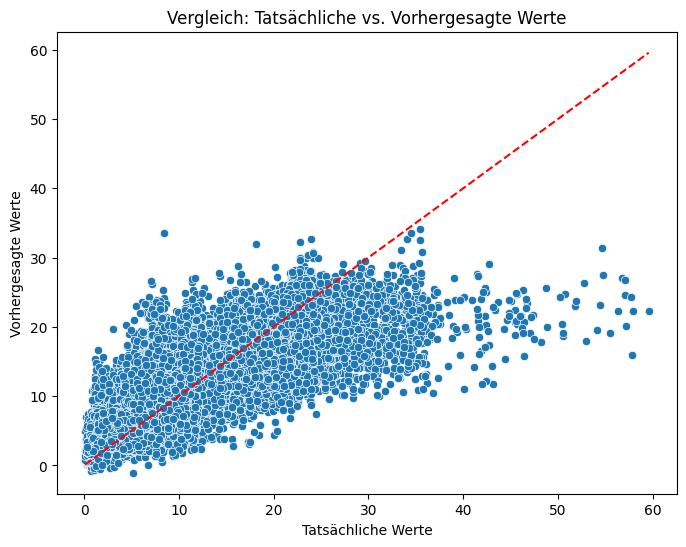

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--")  # Perfekte Linie
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte")
plt.title("Vergleich: Tatsächliche vs. Vorhergesagte Werte")
plt.show()


**auf overfitting testen**

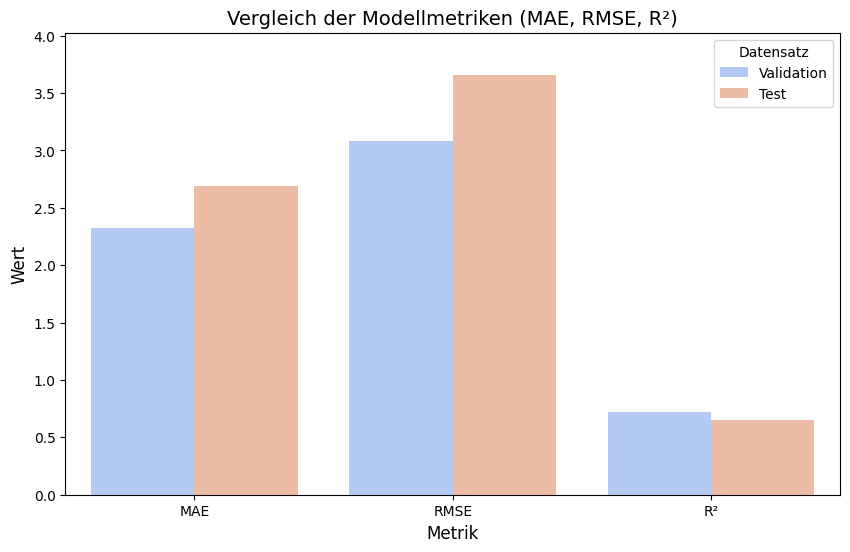

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mae_val, rmse_val, r2_val = 2.32, 3.08, 0.719
mae_test, rmse_test, r2_test = 2.69, 3.66, 0.647

data = pd.DataFrame({
    'Metrik': ['MAE', 'RMSE', 'R²'],
    'Validation': [ mae_val, rmse_val, r2_val],
    'Test': [ mae_test, rmse_test, r2_test]
})# Umstrukturieren für die Visualisierung
data_melted = data.melt(id_vars=['Metrik'], var_name='Datensatz', value_name='Wert')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrik', y='Wert', hue='Datensatz', data=data_melted, palette='coolwarm')
plt.title("Vergleich der Modellmetriken (MAE, RMSE, R²)", fontsize=14)
plt.xlabel("Metrik", fontsize=12)
plt.ylabel("Wert", fontsize=12)
plt.legend(title="Datensatz")
plt.ylim(0, max(data_melted["Wert"]) * 1.1) 
plt.show()

**FAZIT**

Das Modell performt bisher nur mittelmäßig und sollte verbessert werden. 
Ein starkes Overfitting ist jedoch nicht erkennbar, obwohl die Auswahl der besten Parameter beim Gridsearch mit subsample:1.0 dies sehr wahrscheinlich gemacht hatte

-----
### unwichtige Features entfernen Methode 2

nachfolgend wurde die automatisierte Enfternung unwichtier Features mittels RFECV (Recursive Feature Elimination mit Cross-Validation) ausprobiert

In [134]:
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

X_train_2 = X_train.drop(columns=['year'])
X_val_2 = X_val.drop(columns=['year'])

# XGBoost-Modell
model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)

# RFECV: Findet die optimale Anzahl an Features automatisch
selector = RFECV(
    estimator=model, 
    step=1,  # Features nacheinander entfernen
    cv=KFold(n_splits=5, shuffle=True, random_state=42),  # Cross-Validation
    scoring="neg_mean_squared_error"  # Oder eine andere Metrik
)

# Feature Selection auf Trainingsdaten anwenden
selector.fit(X_train_2, y_train)

# Beste Feature-Maske extrahieren
selected_features = X_train_2.columns[selector.support_].tolist()

print(f"Behalte {len(selected_features)} Features nach RFECV:")
print(selected_features)

# Reduziertes Dataset erstellen
X_train_filtered2 = X_train_2[selected_features]
X_val_filtered2 = X_val_2[selected_features]


Behalte 15 Features nach RFECV:
['Tour', 'Wochentag', 'TageZuvorNichtGeliefert', 'Saison_Winter', 'Tonnage_dealy_1', 'Tonnage_dealy_2', 'Tonnage_dealy_3', 'Tonnage_dealy_4', 'Tonnage_dealy_5', 'Tonnage_dealy_7', 'Tonnage_dealy_8', 'Hof_VMG', 'Hof_VMM', 'Hof_VMN', 'Abfallart_HM']


**-> es werden hier weitaus weniger Features behalten als bei meiner manuellen Auswahl zuvor**

---
**Modell2 trainieren mit den 15 Features**

In [136]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Modell mit den besten Features trainieren
model.fit(X_train_filtered2, y_train)

# Vorhersagen für Train & Validation
y_train_pred = model.predict(X_train_filtered2)
y_val_pred = model.predict(X_val_filtered2)

# Metriken berechnen
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"🔹 Ergebnisse für {dataset_name}:")
    print(f"   ➤ MAE:  {mae:.4f}")
    print(f"   ➤ MSE:  {mse:.4f}")
    print(f"   ➤ RMSE: {rmse:.4f}")
    print(f"   ➤ R²:   {r2:.4f}\n")

# Metriken für Trainings- und Validierungsdaten ausgeben
evaluate_model(y_train, y_train_pred, "Trainingsdaten")
evaluate_model(y_val, y_val_pred, "Validierungsdaten")


🔹 Ergebnisse für Trainingsdaten:
   ➤ MAE:  2.2979
   ➤ MSE:  9.2871
   ➤ RMSE: 3.0475
   ➤ R²:   0.7375

🔹 Ergebnisse für Validierungsdaten:
   ➤ MAE:  2.4653
   ➤ MSE:  10.5250
   ➤ RMSE: 3.2442
   ➤ R²:   0.6903



---
### HyperparameterTuning 2

für das HyperparameterTuning werden der neue nur noch aus 15 Features bestehende Datensatz benutzt 

In [138]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],  # Anzahl der Bäume
    'max_depth': [3, 5, 7],  # Maximale Tiefe der Bäume
    'learning_rate': [0.01, 0.05, 0.1],  # Lernrate
    'subsample': [0.7, 0.8, 1.0],  # Anteil der verwendeten Daten pro Baum
    'colsample_bytree': [0.7, 0.8, 1.0],  # Anteil der Spalten pro Baum
}
 # XGBoost Modell definieren
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# GridSearch mit 5-facher Kreuzvalidierung
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,  
    verbose=1
)

# GridSearch starten - mit X_train_filterd2! 
grid_search.fit(X_train_filtered2, y_train)

# Beste Parameter ausgeben
print("Beste Hyperparameter:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Users/blongsch/ikt/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Beste Hyperparameter: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


Im Vergleich dazu waren die besten Hyperparamter des anderen Datensatzes :  
Beste Hyperparameter: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


-----------------------------
**beste Parameter im Training anwenden**

In [140]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time 

# Beste Hyperparameter aus GridSearchCV
best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'max_depth': 7,
    'n_estimators': 300,
    'subsample': 0.8
}

# Modell initialisieren mit besten Hyperparametern
final_model2 = xgb.XGBRegressor(**best_params, objective="reg:squarederror")


start_time = time.time()
# Modell mit Trainingsdaten (2019-2021) trainieren (Jahr wird nicht verwendet)
final_model2.fit(X_train_filtered2, y_train)
end_time = time.time()

train_time = end_time - start_time
print(f"Trainingszeit: {train_time:.2f} Sekunden")

# Vorhersagen für das Validierungsjahr 2022
y_pred_val = final_model2.predict(X_val_filtered2)

# Metriken berechnen
mae = mean_absolute_error(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)
r2 = r2_score(y_val, y_pred_val)

# Ergebnisse ausgeben
print(f"Neuer MAE nach Tuning2: {mae:.8f}")
print(f"Neuer RMSE nach Tuning2: {rmse:.8f}")
print(f"Neuer R²-Score nach Tuning2: {r2:.8f}")

Trainingszeit: 1.65 Sekunden
Neuer MAE nach Tuning2: 2.28848671
Neuer RMSE nach Tuning2: 3.06985691
Neuer R²-Score nach Tuning2: 0.72268556


/Users/blongsch/ikt/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


**Im Vergleich die Ergebnisse des ersten Modells:**
Trainingszeit: 1.56 Sekunden
Neuer MAE nach Tuning: 2.32317301
Neuer RMSE nach Tuning: 3.08802886
Neuer R²-Score nach Tuning: 0.71939273


-------------
**auf Testdaten anwenden**  

getuntes Modell2

In [143]:
X_test2 = X_test.drop(columns=['year'])
X_test_filtered2 = X_test2[selected_features]

# Vorhersage auf den Testdaten
y_pred_test2 = final_model2.predict(X_test_filtered2)

# Metriken berechnen
mae_test = mean_absolute_error(y_test, y_pred_test2)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test2))
r2_test = r2_score(y_test, y_pred_test2)

# Ergebnisse ausgeben
print(f"MAE auf Testdaten nach Tuning: {mae_test:.8f}")
print(f"RMSE auf Testdaten nach Tuning: {rmse_test:.8f}")
print(f"R²-Score auf Testdaten nach Tuning: {r2_test:.8f}")

MAE auf Testdaten nach Tuning: 2.64748179
RMSE auf Testdaten nach Tuning: 3.63315272
R²-Score auf Testdaten nach Tuning: 0.65365344


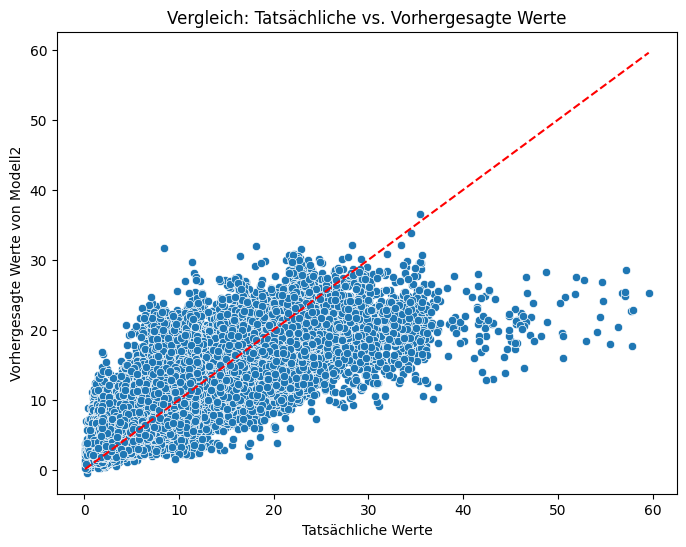

In [144]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_test2)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--")  # Perfekte Linie
plt.xlabel("Tatsächliche Werte")
plt.ylabel("Vorhergesagte Werte von Modell2")
plt.title("Vergleich: Tatsächliche vs. Vorhergesagte Werte")
plt.show()


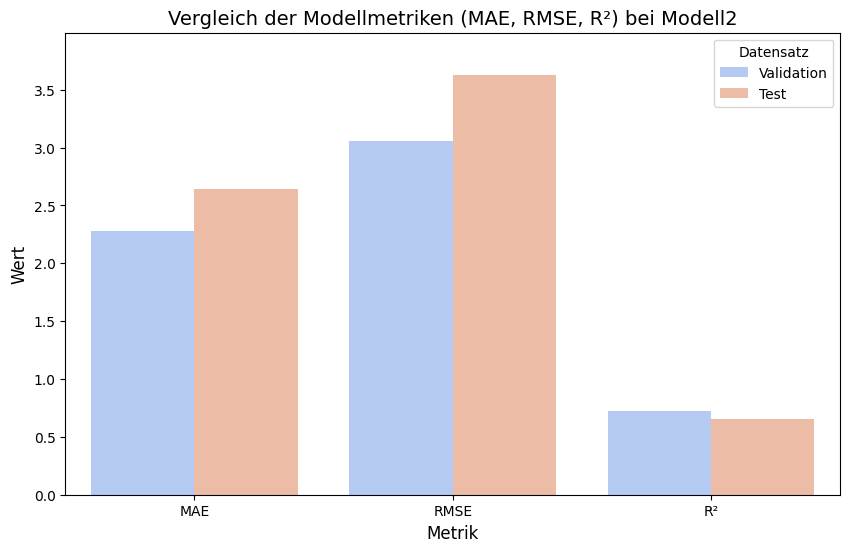

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

mae_val, rmse_val, r2_val = 2.28, 3.06, 0.722
mae_test, rmse_test, r2_test = 2.64, 3.63, 0.653

data = pd.DataFrame({
    'Metrik': ['MAE', 'RMSE', 'R²'],
    'Validation': [ mae_val, rmse_val, r2_val],
    'Test': [ mae_test, rmse_test, r2_test]
})# Umstrukturieren für die Visualisierung
data_melted = data.melt(id_vars=['Metrik'], var_name='Datensatz', value_name='Wert')
plt.figure(figsize=(10, 6))
sns.barplot(x='Metrik', y='Wert', hue='Datensatz', data=data_melted, palette='coolwarm')
plt.title("Vergleich der Modellmetriken (MAE, RMSE, R²) bei Modell2", fontsize=14)
plt.xlabel("Metrik", fontsize=12)
plt.ylabel("Wert", fontsize=12)
plt.legend(title="Datensatz")
plt.ylim(0, max(data_melted["Wert"]) * 1.1) 
plt.show()

#### FAZIT

beide Ansätze haben keine gut funktionierendes Modell geliefert.
Modell2 hat auf den Validierungsdaten etwas besser abgeschnitten, aber auf den Testdaten nicht signifikant besser performt. - war also eher von Overfitting betroffen.

Die Methode des manuellen Herausfilterns von wichtigen Features war für die Modellentwicklung in diesem Fall also etwas besser.